In [1]:
library(reticulate)
library(tidyverse)

Warning message:
“Your system is mis-configured: ‘/etc/localtime’ is not a symlink”
Warning message:
“It is strongly recommended to set envionment variable TZ to ‘Etc/UCT’ (or equivalent)”
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.7
✔ tidyr   1.1.4     ✔ stringr 1.4.0
✔ readr   2.1.0     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



In [2]:
boto3_r <- import('boto3')
client = boto3_r$client('sagemaker-runtime')

sagemaker  <- import('sagemaker')
csv_serializer = sagemaker$serializers$CSVSerializer(content_type='text/csv')

json <- import("json")

In [3]:
# example data
ID=41414
test_plus <- read_csv(file = str_glue('data', ID, 'test', 'test_plus.csv', .sep='/'), col_names = NULL, )
test_sample <- as.matrix(test_plus[-1])
head(test_sample)

Rows: 1325 Columns: 4

── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (4): X1, X2, X3, X4


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.



X2,X3,X4
302.7359,300.3213,17.27643
302.0654,300.4139,16.79956
301.4309,300.5081,16.27917
301.4774,300.5800,15.85849
301.5676,300.6251,15.57870
302.0559,300.6421,15.46696


In [14]:
# csv_serializer$serialize(test_sample[1,])

[1] "302.7359313964844,300.3213141711462,17.276427268981934"

In [27]:
# custom_attributes = "..."
endpoint_name = "endpointname" # Your endpoint name.
content_type = "text/csv" # The MIME type of the input data in the request body.
# accept = "..." # The desired MIME type of the inference in the response.
my_payload_as_csv = csv_serializer$serialize(test_sample) # Payload (aka, data) for inference.
targetmodel=str_c("/", ID, "_model.tar.gz") # name of target model (as saved in S3 multimodel)
response = client$invoke_endpoint(
    EndpointName=endpoint_name, 
#     CustomAttributes=custom_attributes, 
    ContentType=content_type,
#     Accept=accept,
    Body=my_payload_as_csv,
    TargetModel=targetmodel
)

temp <- json$loads(response$Body$read()) # decoding response Body which comes in json format
temp <- as_tibble(temp)
temp <- sapply(temp, extract_numeric)
preds_ep = cbind(temp, rep(ID, nrow(test_plus)), test_plus)
colnames(preds_ep) = c("predicted_NO2", "id", "NO2", "RAW", "baseline", "temperature")
head(preds_ep)

extract_numeric() is deprecated: please use readr::parse_number() instead



,predicted_NO2,id,NO2,RAW,baseline,temperature
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,20.95129,41414,20.91667,302.7359,300.3213,17.27643
2,18.42395,41414,19.25000,302.0654,300.4139,16.79956
3,15.99829,41414,16.95000,301.4309,300.5081,16.27917
4,15.92657,41414,16.06667,301.4774,300.5800,15.85849
5,16.08063,41414,16.39167,301.5676,300.6251,15.57870
6,17.66779,41414,17.25000,302.0559,300.6421,15.46696


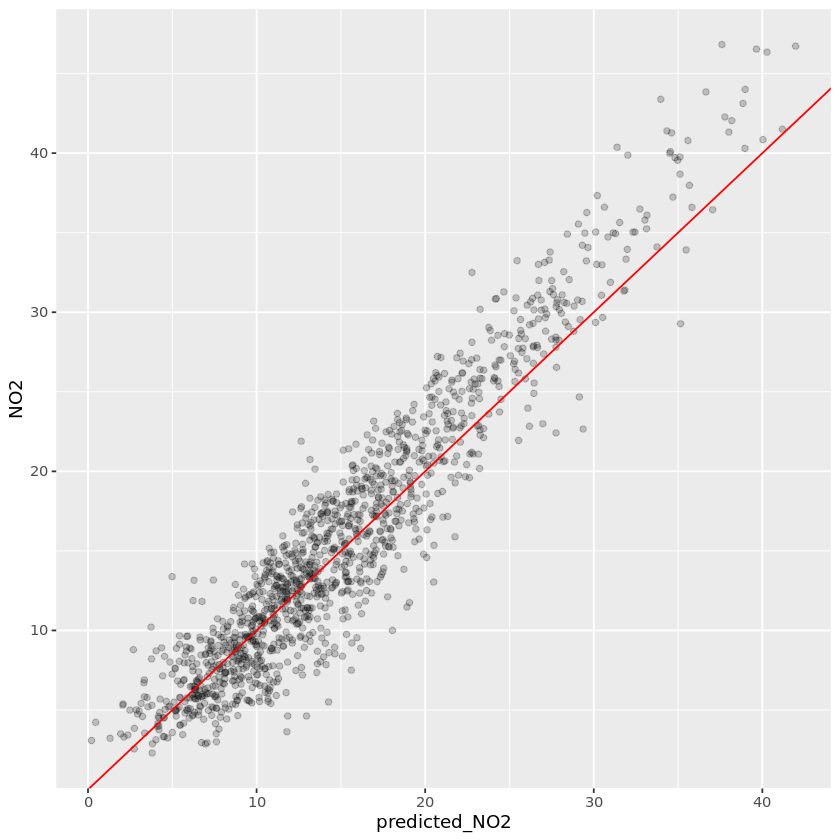

In [29]:
preds_ep %>% 
    ggplot(aes(x=predicted_NO2, y=NO2)) +
    geom_point(alpha=0.2) +
    geom_abline(slope=1, intercept=0, col="red")
#     facet_wrap(~id)